#  Trigger word detection

**"Activate"** is the trigger word trained for the model.


In [32]:
import numpy as np
import time
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
# To generate wav file from np array.
from scipy.io.wavfile import write
%matplotlib inline

In [33]:

Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [34]:
# Use 272 for 2sec input audio
Ty = 1375# The number of time steps in the output of our model

## Build the model

In [35]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Conv2D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

from keras import losses
from keras import metrics
from keras import optimizers
from keras.activations import linear
from keras.engine import InputLayer
from keras.layers import Dense
import tensorflow as tf
from keras.models import load_model

In [36]:
# GRADED FUNCTION: model

def model(input_shape):
  
    
    X_input = Input(shape = input_shape)
    
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)                                 # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units=128, return_sequences=True)(X)                                 # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units=128, return_sequences=True)(X)                                 # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [37]:
model = model(input_shape = (Tx, n_freq))
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5511, 101)]       0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization_6 (Batch (None, 1375, 196)         784       
_________________________________________________________________
activation_2 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1375, 196)         0         
_________________________________________________________________
gru_4 (GRU)                  (None, 1375, 128)         125184    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1375, 128)        

In [38]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

## Load model

In [39]:
tf.compat.v1.disable_v2_behavior() # model trained in tf1


In [40]:
model = tf.compat.v1.keras.models.load_model('tr_model.h5')

### Detect trigger word functions

In [41]:
def detect_triggerword_spectrum(x):
    """
    Function to predict the location of the trigger word.
    """
    # the spectogram outputs  and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    return predictions.reshape(-1)

def has_new_triggerword(predictions, chunk_duration, feed_duration, threshold=0.5):
    """
    Function to detect new trigger word in the latest chunk of input audio.
    """
    predictions = predictions > threshold
    chunk_predictions_samples = int(len(predictions) * chunk_duration / feed_duration)
    chunk_predictions = predictions[-chunk_predictions_samples:]
    level = chunk_predictions[0]
    for pred in chunk_predictions:
        if pred > level:
            return True
        else:
            level = pred
    return False
    
    

# Record audio stream from mic

In [42]:
chunk_duration = 0.5 # Each read length in seconds from mic.
fs = 44100 # sampling rate for mic
chunk_samples = int(fs * chunk_duration) # Each read length in number of samples.

# Each model input data duration in seconds, need to be an integer numbers of chunk_duration
feed_duration = 10
feed_samples = int(fs * feed_duration)

assert feed_duration/chunk_duration == int(feed_duration/chunk_duration)

In [43]:
def get_spectrogram(data):
    """
    Function to compute a spectrogram.
    Returns:
    spectrogram, 2-D array, columns are the periodograms of successive segments.
    """
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, _, _ = mlab.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, _, _ = mlab.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

In [44]:
def plt_spectrogram(data):
    """
    Function to compute and plot a spectrogram.
    """
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, _, _, _ = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, _, _, _ = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

### Audio stream

In [45]:
def get_audio_input_stream(callback):
    stream = pyaudio.PyAudio().open(
        format=pyaudio.paInt16,
        channels=1,
        rate=fs,
        input=True,
        frames_per_buffer=chunk_samples,
        input_device_index=0,
        stream_callback=callback)
    return stream

In [49]:
import pyaudio
from queue import Queue
from threading import Thread
import sys
import time


# Queue to communiate between the audio callback and main thread
q = Queue()

run = True

silence_threshold = 100

# Run the demo for a timeout seconds
timeout = time.time() + 0.5*60  # 0.5 minutes from now

# Data buffer for the input wavform
data = np.zeros(feed_samples, dtype='int16')

def callback(in_data, frame_count, time_info, status):
    global run, timeout, data, silence_threshold    
    if time.time() > timeout:
        run = False        
    data0 = np.frombuffer(in_data, dtype='int16')
    if np.abs(data0).mean() < silence_threshold:
        sys.stdout.write('-')
        return (in_data, pyaudio.paContinue)
    else:
        sys.stdout.write('.')
    data = np.append(data,data0)    
    if len(data) > feed_samples:
        data = data[-feed_samples:]
        # Process data async by sending a queue.
        q.put(data)
    return (in_data, pyaudio.paContinue)

stream = get_audio_input_stream(callback)
stream.start_stream()


try:
    while run:
        data = q.get()
        spectrum = get_spectrogram(data)
        preds = detect_triggerword_spectrum(spectrum)
        new_trigger = has_new_triggerword(preds, chunk_duration, feed_duration)
        if new_trigger:
            sys.stdout.write('1')
except (KeyboardInterrupt, SystemExit):
    stream.stop_stream()
    stream.close()
    timeout = time.time()
    run = False
        
stream.stop_stream()
stream.close()

-.---...---..----..1---.....---...-1--..------.-----...--.....

In [50]:
stream.stop_stream()
stream.close()

## Print the mean magnitude for each chunk of audio data
You can play around it to find a suitable `silence_threshold` for the previous demo.

In [48]:
import time
import pyaudio
import numpy as np
data_c = None


def callback(in_data, frame_count, time_info, status):
    global data_c
    data_c = np.frombuffer(in_data, dtype='int16')
    print(np.abs(data_c).mean())
    return (in_data, pyaudio.paContinue)

stream = pyaudio.PyAudio().open(
    format=pyaudio.paInt16,
    channels=1,
    rate=fs,
    input=True,
    frames_per_buffer=chunk_samples,
    input_device_index=0,
    stream_callback=callback)
stream.start_stream()
time.sleep(5.1)
stream.stop_stream()
stream.close()

148.3780045351474
162.80526077097505
118.94136054421769
153.10290249433106
145.8509297052154
98.16598639455782
60.31687074829932
86.06253968253968
55.121814058956915
103.41083900226758


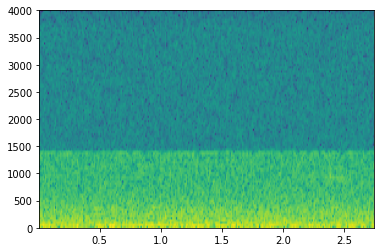

In [19]:
pxx = plt_spectrogram(data_c)

In [19]:
write('./demo/test.wav', 44100, data_c)

FileNotFoundError: [Errno 2] No such file or directory: './demo/test.wav'

In [20]:
IPython.display.Audio("./demo/test.wav")

ValueError: rate must be specified when data is a numpy array or list of audio samples.